In [1]:
#-*- codeing = utf-8 -*-

from selenium import webdriver
import re
import requests
import json
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from threading import *
from openpyxl import Workbook

In [ ]:
class GetInfo():
    def __init__(self, user_id):
        self.a_list = []  # 存储每一个视频的url
        self.data_list = []
        self.d = webdriver.Chrome()  # 初始化Chrome浏览器驱动
        self.user_id = user_id
        self.base_url = f'https://space.bilibili.com/{user_id}/video'
        self.d.get(self.base_url)
        #这篇文章写于2022年，当时B站免登入可以搜索视频，查看视频，但是这段时间再次尝试爬取资源时，加了必须认证登入，尝试过很多次，没有获取token，只能老老实实，登入后再去爬取信息
        #time.sleep(10)
        #print("速度扫码登入")

    def get_url(self):
        # 从当前页面获取所有视频的URL并保存到本地文件
        ul=WebDriverWait(self.d, 10).until(lambda x: x.find_element(By.XPATH, '//*[@id="submit-video-list"]/ul[1]'))
        lis = ul.find_elements(By.XPATH, "li")
        for li in lis:
            self.a_list.append(li.get_attribute("data-aid"))
        with open("url.json", "w+", encoding="utf-8") as f:
            data = json.dumps(self.a_list, ensure_ascii=False)  # 确保中文字符正常保存
            f.write(data)  # 使用write而不是writelines

    def next_page(self):
        # 遍历所有页面，获取所有视频的URL）
        total = WebDriverWait(self.d, 10).until(
            lambda x: x.find_element(By.XPATH, '//*[@id="submit-video-list"]/ul[3]/span[1]'))
        number = re.findall(r"\d+", total.text)
        n = int(number[0])
        

        for page in range(1, n):
            try:
                self.d.find_element(By.LINK_TEXT, '下一页').click()
                time.sleep(2)  # 等待页面加载
                self.get_url()  # 修复方法名错误
            except Exception as e:
                print(f"Failed to click next page: {e}")

        return self.a_list

    def get_video(self, urls, start, end):
        # 使用requests.Session()来复用TCP连接
        with requests.Session() as session:
            session.headers.update({
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
            })
            base_url = "https://www.bilibili.com/video/"

            # 预编译正则表达式以提高性能
            title_pattern = re.compile(r'<title data-vue-meta="true">([^&amp;]+)</title>')
            play_count_pattern = re.compile(r'视频播放量 (\d+)')
            danmu_count_pattern = re.compile(r'弹幕量 (\d+)')
            like_count_pattern = re.compile(r'点赞数 (\d+)')
            coin_count_pattern = re.compile(r'投硬币枚数 (\d+)')
            favorite_count_pattern = re.compile(r'收藏人数 (\d+)')
            share_count_pattern = re.compile(r'转发人数 (\d+)')
            publish_time_pattern = re.compile(r'<div class="pubdate-ip-text"[^>]*>([^<]+)</div>')


            for url in urls[int(start):int(end)]:
                full_url = base_url + url
                try:
                    response = session.get(full_url)
                    if response.status_code == 200:
                        string = response.text
                        # 使用正则表达式提取视频信息
                        title_match = title_pattern.search(string)
                        title = title_match.group(1) if title_match else "未找到匹配的内容"

                        # 提取视频播放量、弹幕量等信息
                        play_count = play_count_pattern.search(string).group(1) if play_count_pattern.search(
                            string) else '0'
                        danmu_count = danmu_count_pattern.search(string).group(1) if danmu_count_pattern.search(
                            string) else '0'
                        like_count = like_count_pattern.search(string).group(1) if like_count_pattern.search(
                            string) else '0'
                        coin_count = coin_count_pattern.search(string).group(1) if coin_count_pattern.search(
                            string) else '0'
                        favorite_count = favorite_count_pattern.search(string).group(
                            1) if favorite_count_pattern.search(string) else '0'
                        share_count = share_count_pattern.search(string).group(1) if share_count_pattern.search(
                            string) else '0'
                        publish_time_match = publish_time_pattern.search(string)
                        publish_time = publish_time_match.group(1) if publish_time_match else "未找到发布时间"


                        # 将提取的信息添加到self.data_list中
                        video_info = {
                            "url": full_url,
                            "title": title,
                            "play_count": play_count,
                            "danmu_count": danmu_count,
                            "like_count": like_count,
                            "coin_count": coin_count,
                            "favorite_count": favorite_count,
                            "share_count": share_count,
                            "publish_time": publish_time
                        }
                        self.data_list.append(video_info)
                    else:
                        print(f"Failed {full_url}: HTTP {response.status_code}")
                except Exception as e:
                    print(f"Failed to get video info for url {full_url}: {e}")


    def save_to_excel(self, filename):
        wb = Workbook()
        ws = wb.active
        ws.append(['url','标题', '播放量', '弹幕数', '点赞数', '投币数', '收藏数', '分享数', '发布时间'])  # 添加表头
        for video_info in self.data_list:
            ws.append([
                video_info['url'],
                video_info['title'],
                video_info['play_count'],
                video_info['danmu_count'],
                video_info['like_count'],
                video_info['coin_count'],
                video_info['favorite_count'],
                video_info['share_count'],
                video_info['publish_time']
            ])
            wb.save(filename)

    def run(self):
        # 运行整个流程
        self.get_url()  # 获取当前页面的视频URL
        self.next_page()  # 遍历所有页面获取视频URL

        with open("url.json", "r", encoding="utf-8") as f:
            data = json.load(f)

            # 使用多线程提高数据获取效率
        threads = []
        part = int(len(data) / 3)
        for i in range(3):
            start = i * part
            end = (i + 1) * part if i != 2 else len(data)
            thread = Thread(target=self.get_video, args=(data, start, end))
            threads.append(thread)
            thread.start()

        for thread in threads:
            thread.join()  # 等待所有线程完成

            # 所有线程完成后，保存数据到Excel
        self.save_to_excel('final_video_info1.xlsx')
        


if __name__ == '__main__':
    obj = GetInfo(user_id='208130286')
    obj.run()  # 运行整个流程

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [3]:
# df = pd.read_excel('final_video_info1.xlsx')
# df.to_csv('dawushiye.csv',encoding='utf-8')
df = pd.read_csv('dawushiye.csv')

In [4]:
df.head()

,Unnamed: 0,url,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
0,0,https://www.bilibili.com/video/BV1rT411x7m8,第N次被现场种草！医生们觉得好用却被雪藏的护肤品_哔哩哔哩_bilibili,2221643,1967,79552,4404,19802,3599,2023-05-19 17:45:00
1,1,https://www.bilibili.com/video/BV1Vb4y1p7Jo,手指割伤被拒诊？头部三甲医院连这都治不了？_哔哩哔哩_bilibili,433015,309,12323,1760,629,339,2022-03-22 20:05:18
2,2,https://www.bilibili.com/video/BV1JA22YHEYt,一封信乐三天！医生和感谢信的故事！看得人心暖暖的！_哔哩哔哩_bilibili,369350,2642,21118,7995,2747,1261,2024-10-11 18:00:00
3,3,https://www.bilibili.com/video/BV1ML411675D,磨牙是肚里有蛔虫？舌苔真的能反映健康吗？牙膏能治幽门螺杆菌？口腔专家在线答疑！_哔哩哔哩_b...,499401,2236,21695,5786,2268,2385,2023-05-17 18:00:00
4,4,https://www.bilibili.com/video/BV1Qw24YJE2D,两年还没入门！这个临床医学怎么越学越慌张！【临床医学生系列】_哔哩哔哩_bilibili,335054,1964,19166,7908,2252,660,2024-10-09 18:00:00


In [5]:
df.dtypes

Unnamed: 0     int64
url           object
标题            object
播放量            int64
弹幕数            int64
点赞数            int64
投币数            int64
收藏数            int64
分享数            int64
发布时间          object
dtype: object

In [12]:
df = df.drop(df[df['发布时间'] == '未找到发布时间'].index)
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['发布时间'] = df['发布时间'].dt.normalize()

In [14]:
df = df.drop(['Unnamed: 0', 'url'],axis=1)

In [ ]:
df[df['标题']=='未找到匹配的内容']

In [ ]:
#df[87,0]= '【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？'

In [25]:
df.iloc[88,1]

2825416

In [26]:
df.loc[88]

标题                 未找到匹配的内容
播放量                 2825416
弹幕数                    5427
点赞数                   89774
投币数                   43651
收藏数                   20268
分享数                   28133
发布时间    2021-12-09 00:00:00
Name: 88, dtype: object

In [28]:
df.loc[88,'标题'] = '【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？'

In [29]:
df.loc[88]

标题      【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？
播放量                                        2825416
弹幕数                                           5427
点赞数                                          89774
投币数                                          43651
收藏数                                          20268
分享数                                          28133
发布时间                           2021-12-09 00:00:00
Name: 88, dtype: object

In [30]:
df.nlargest(n=5,columns='播放量')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
120,王者荣耀真人硬核模仿合辑（八）_哔哩哔哩_bilibili,3594406,1455,99091,8757,7899,5473,2021-06-02
36,医生出120遇到的都是什么狗血剧情？打120怎么沟通更有效？【医生聊天室】_哔哩哔哩_bil...,3110294,8947,107208,28333,10737,4962,2023-04-12
88,【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？,2825416,5427,89774,43651,20268,28133,2021-12-09


In [31]:
df.nlargest(n=5,columns='弹幕数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
335,华语TOP100！挑战猜歌名！每一首都是青春！_哔哩哔哩_bilibili,1272851,19483,38583,11863,5938,3627,2023-09-20
332,华语TOP50猜歌名！有人急红了脸，有人唱湿了眼…_哔哩哔哩_bilibili,1181940,17174,43925,24845,6811,3137,2023-09-22
207,【年终大抽奖】医生也送智商税？录制现场秒变许愿屋？都进来接好运吧！_哔哩哔哩_bilibili,827790,14763,45570,29424,6928,2197,2024-02-07
386,衣服时尚了，人丑了！医学博士赶潮流的n种翻车方式_哔哩哔哩_bilibili,649017,12570,32748,11093,2387,1338,2023-07-19
24,保健品有用吗？女性求职难？医生狠起来连自己人都吐槽！_哔哩哔哩_bilibili,720137,11494,32975,16533,3709,1013,2022-02-18


In [32]:
df.nlargest(n=5,columns='点赞数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
227,王者荣耀真人硬核模仿合辑（三）_哔哩哔哩_bilibili,2695947,6010,192187,94664,33164,27236,2019-12-13
117,工科男模仿美少女战士变身，比官方真人版更还原！_哔哩哔哩_bilibili,2493924,9925,150182,89867,36657,84277,2021-06-10
235,王者荣耀真人硬核模仿合辑（二）_哔哩哔哩_bilibili,2329673,5728,147290,70718,24594,22405,2019-10-26


In [33]:
df.nlargest(n=5,columns='投币数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
227,王者荣耀真人硬核模仿合辑（三）_哔哩哔哩_bilibili,2695947,6010,192187,94664,33164,27236,2019-12-13
117,工科男模仿美少女战士变身，比官方真人版更还原！_哔哩哔哩_bilibili,2493924,9925,150182,89867,36657,84277,2021-06-10
235,王者荣耀真人硬核模仿合辑（二）_哔哩哔哩_bilibili,2329673,5728,147290,70718,24594,22405,2019-10-26


In [34]:
df.nlargest(n=5,columns='分享数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
117,工科男模仿美少女战士变身，比官方真人版更还原！_哔哩哔哩_bilibili,2493924,9925,150182,89867,36657,84277,2021-06-10
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
124,鼻炎/咽炎/喉炎丨耳鼻喉科三大“绝症”怎么治？_哔哩哔哩_bilibili,1196276,5166,49322,21901,31871,28977,2024-05-22
88,【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？,2825416,5427,89774,43651,20268,28133,2021-12-09


In [35]:
df.nlargest(n=5,columns='收藏数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
203,35位医生投票：家中常备什么药？竟然有一个德不配位！_哔哩哔哩_bilibili,1555980,8883,73445,39084,52700,26417,2024-02-23
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
132,传统工科出路在哪？一个视频讲透机械类所有专业/行业！【框框的b站大学-机械类】机械工程、机械...,1493099,3643,49242,17425,47730,18611,2023-01-07
117,工科男模仿美少女战士变身，比官方真人版更还原！_哔哩哔哩_bilibili,2493924,9925,150182,89867,36657,84277,2021-06-10


In [36]:
df.nlargest(n=5,columns='分享数')

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
241,王者荣耀真人硬核模仿合辑（一）_哔哩哔哩_bilibili,4403653,8173,272810,134256,83579,100425,2019-09-23
117,工科男模仿美少女战士变身，比官方真人版更还原！_哔哩哔哩_bilibili,2493924,9925,150182,89867,36657,84277,2021-06-10
181,王者荣耀真人硬核模仿合辑（六）_哔哩哔哩_bilibili,5546602,11458,337597,96864,50283,51503,2020-04-24
124,鼻炎/咽炎/喉炎丨耳鼻喉科三大“绝症”怎么治？_哔哩哔哩_bilibili,1196276,5166,49322,21901,31871,28977,2024-05-22
88,【Offer4 Reaction】建筑师是怎么看待风水的？元宇宙已经渗透入建筑学了？,2825416,5427,89774,43651,20268,28133,2021-12-09


In [37]:
df.corr(method = 'spearman') # 播放量-点赞数 0.93，收藏数-分享数 0.91，投币数-点赞数 0.91

,播放量,弹幕数,点赞数,投币数,收藏数,分享数
播放量,1.000000,0.794055,0.931736,0.814175,0.872742,0.809490
弹幕数,0.794055,1.000000,0.801226,0.823379,0.717425,0.629756
点赞数,0.931736,0.801226,1.000000,0.915505,0.894335,0.819778
投币数,0.814175,0.823379,0.915505,1.000000,0.831374,0.720418
收藏数,0.872742,0.717425,0.894335,0.831374,1.000000,0.914508
分享数,0.809490,0.629756,0.819778,0.720418,0.914508,1.000000


In [40]:
from pyecharts.charts import Line #折线图所导入的包
from pyecharts import options as opts #全局设置所导入的包

In [50]:
df.dtypes

标题              object
播放量              int64
弹幕数              int64
点赞数              int64
投币数              int64
收藏数              int64
分享数              int64
发布时间    datetime64[ns]
dtype: object

In [51]:
df['发布时间'].dt.strftime('%Y-%m-%d')

0      2023-05-19
1      2022-03-22
2      2024-10-11
3      2023-05-17
4      2024-10-09
          ...    
427    2023-05-31
428    2022-03-25
429    2023-05-26
430    2023-05-24
431    2023-05-22
Name: 发布时间, Length: 430, dtype: object

In [ ]:
line = (
    Line() # 实例化 Line
    # 加入X轴数据
    .add_xaxis(df['发布时间'].dt.strftime('%Y-%m-%d')) 
    #加入Y轴数据
    .add_yaxis("弹幕数", df['弹幕数'].values.tolist())
    .add_yaxis("播放量", df['播放量'].values.tolist())
    .add_yaxis("点赞数", df['点赞数'].values.tolist())
    .add_yaxis("投币数", df['投币数'].values.tolist())
    .add_yaxis("收藏数", df['收藏数'].values.tolist())
    #.add_yaxis("评论数", df['评论数'].values.tolist())
    .add_yaxis("分享数", df['分享数'].values.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="数据分析"),
                    legend_opts=opts.LegendOpts(is_show=True)
                    )#全局设置项
)

line.render_notebook() 

In [57]:
line.render('chart.html') 

'C:\\Users\\Connor\\数据分析\\chart.html'

In [75]:
df = df.sort_values('发布时间',ascending = True)

In [ ]:
'''
f,[ax1,ax2,ax3,ax4,ax5,ax6]=plt.subplots(6,1,figsize=(20,10))

sns.lineplot(df[''], ax=ax1)
ax1.set_title('1',fontsize=15)
ax1.set_xlabel('发布时间')
ax1.set_ylabel('')
sns.barplot(x='Elevator', y='Price', data=df, ax=ax2)
ax2.set_title('有无电梯房价对比',fontsize=15)
ax2.set_xlabel('发布时间')
ax2.set_ylabel('总价')'''

In [59]:
import matplotlib.pyplot as plt

In [76]:
df.head()

,标题,播放量,弹幕数,点赞数,投币数,收藏数,分享数,发布时间
424,【吃吧大小贰】这些带有地方特色的80后怀旧零食 你有见过吗？_哔哩哔哩_bilibili,49842,150,672,141,53,30,2017-09-07
420,【吃吧大小贰】泪奔！看着这些怀旧零食，想起当年大明湖畔小卖部的老板娘了么？（怀旧零食第二弹）...,7410,88,193,100,17,16,2017-09-07
417,【吃吧大小贰】辣么好吃的零食你知道吗？_哔哩哔哩_bilibili,10899,42,202,82,25,15,2017-09-09
414,【吃吧大小贰】喝完两瓶shī shēn酒，他们还能全身而退？酒鬼特辑_哔哩哔哩_bilibili,8725,33,215,89,19,16,2017-09-10
411,【吃吧大小贰】这些辣到没朋友的零食，他们吃完都哭着还想要_哔哩哔哩_bilibili,9021,53,211,109,18,18,2017-09-14


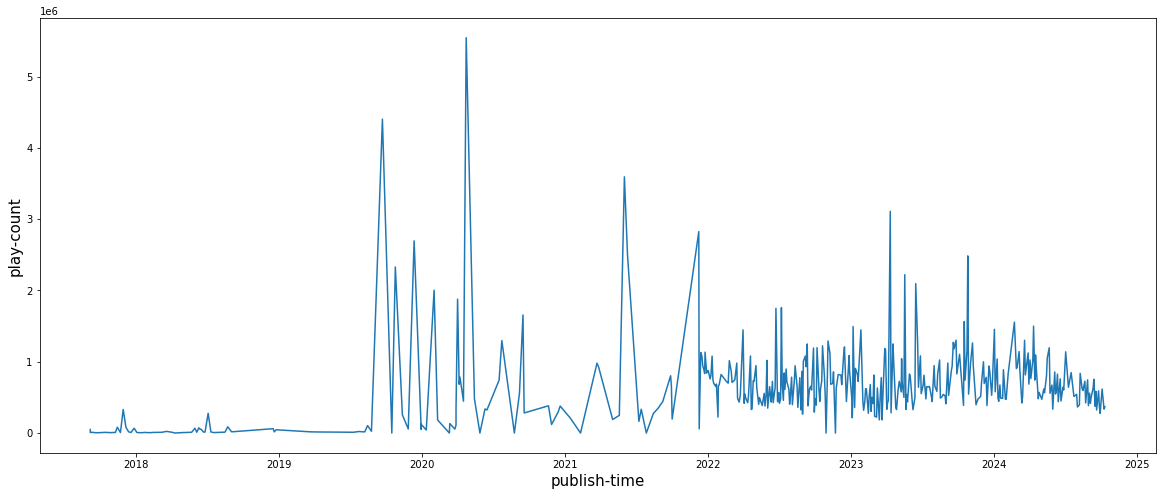

In [88]:
plt.figure(figsize=(20,8))
plt.xlabel('publish-time',fontsize=15)
plt.ylabel('play-count',fontsize=15)
plt.plot(df['发布时间'], df['播放量'])
plt.show()

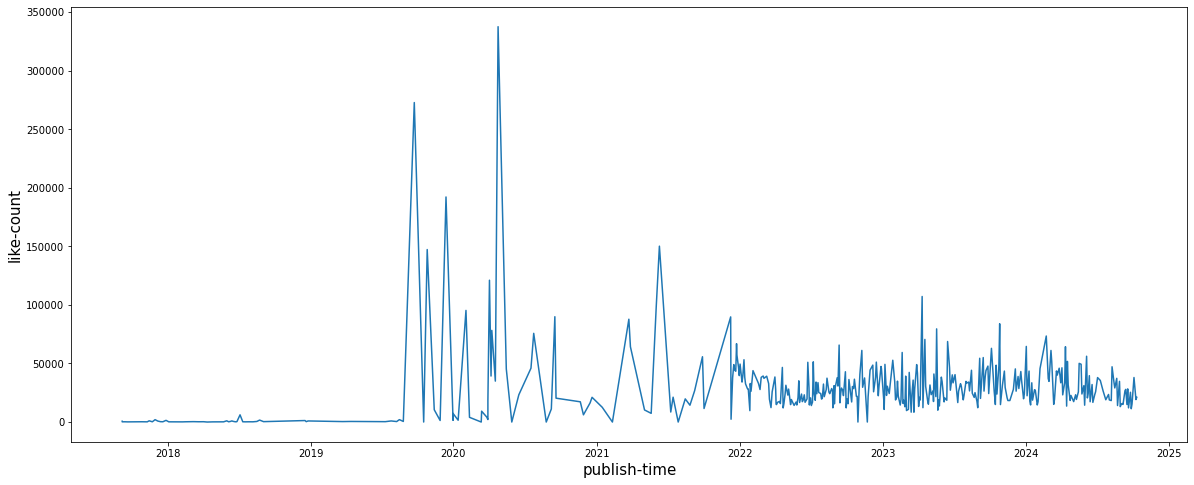

In [89]:
plt.figure(figsize=(20,8))
plt.xlabel('publish-time',fontsize=15)
plt.ylabel('like-count',fontsize=15)
plt.plot(df['发布时间'], df['点赞数'])
plt.show()

C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36190 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Connor\anaconda30\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25237 mi

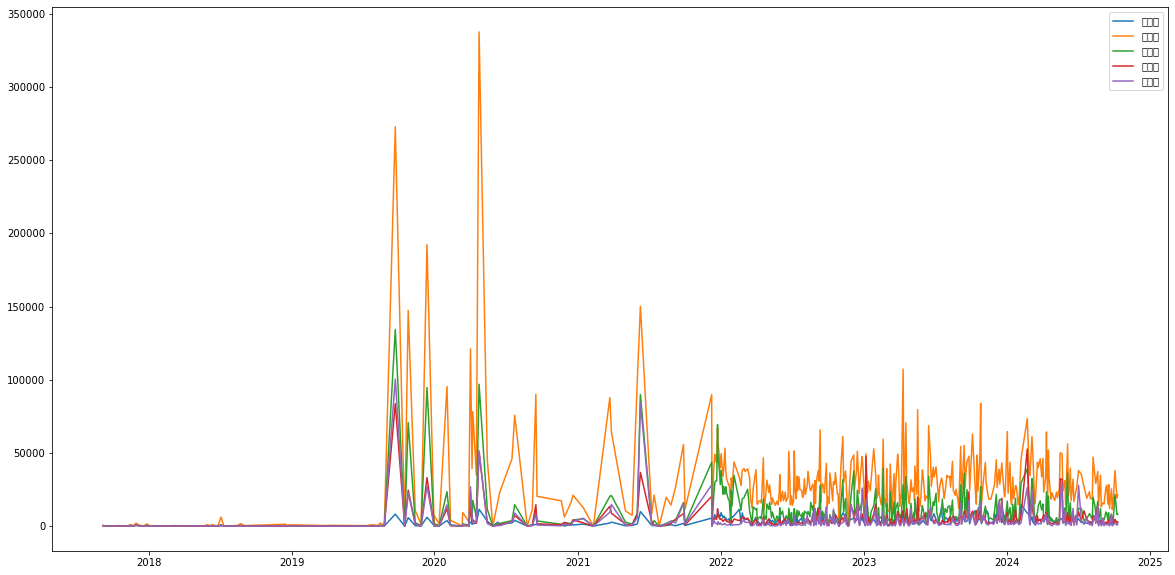

In [87]:
plt.figure(figsize=(20,10))
#plt.plot(df['发布时间'], df['播放量'], label='播放量') 
plt.plot(df['发布时间'], df['弹幕数'], label='弹幕数') 
plt.plot(df['发布时间'], df['点赞数'], label='点赞数')  
plt.plot(df['发布时间'], df['投币数'], label='投币数')  
plt.plot(df['发布时间'], df['收藏数'], label='收藏数')  
plt.plot(df['发布时间'], df['分享数'], label='分享数') 

plt.legend()

In [92]:
df['发布时间'].dt.year

424    2017
420    2017
417    2017
414    2017
411    2017
       ... 
14     2024
10     2024
7      2024
4      2024
2      2024
Name: 发布时间, Length: 430, dtype: int64

In [99]:

# 使用Pandas的groupby方法按照年份进行分组
# 使用size方法来获取每个组的视频数量
# 使用unstack方法来转换数据，使得年份成为索引和列
# 最后，使用reset_index方法来将年份从行索引转换为列
video_yearly = df.groupby(df['发布时间'].dt.year).size()


In [118]:
video_yearly_df = video_yearly.reset_index(name='video count')
video_yearly_df.columns = ['year', 'video count']

<AxesSubplot:xlabel='year', ylabel='video count'>

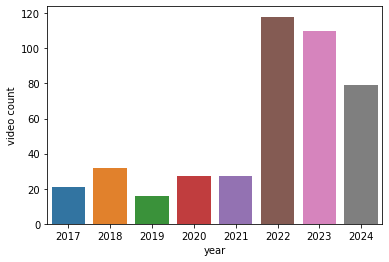

In [119]:
sns.barplot(x=video_yearly_df['year'], y=video_yearly_df['video count'])


In [125]:
df.describe()

,播放量,弹幕数,点赞数,投币数,收藏数,分享数
count,4.300000e+02,430.000000,430.000000,430.000000,430.000000,430.000000
mean,6.319817e+05,3219.560465,27596.769767,10024.620930,4338.855814,3605.397674
std,5.727149e+05,2926.680288,29609.493943,13490.665123,7244.177248,8237.616555
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.313360e+05,915.500000,14118.500000,2681.500000,1046.750000,303.250000
50%,5.521320e+05,2696.500000,23250.500000,6098.000000,2463.500000,1257.500000
75%,8.237598e+05,4554.500000,35488.250000,12954.000000,4919.250000,3115.250000
max,5.546602e+06,19483.000000,337597.000000,134256.000000,83579.000000,100425.000000
